In [1]:
from lightgbm import plot_importance
import pickle

ESTIMATOR_PATH = "../data/best_ranker.dat"

with open(ESTIMATOR_PATH, "rb") as f:
    ranker = pickle.load(f)

plot_importance(ranker._ranker)

AttributeError: 'BetModel' object has no attribute '_ranker'

In [1]:
from datetime import datetime
from typing import List, Tuple
from IPython.display import display, HTML

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

from Experiments.FundHistorySummary import FundHistorySummary


def show_fund_snapshot_graphs(fund_history_summaries: List[FundHistorySummary], win_bet_limit_ratio: float):
    graphs_data = {"date": [], "wealth_snapshots": [], "name": []}
    for fund_history_summary in fund_history_summaries:
        graphs_data["date"] += [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]
        graphs_data["wealth_snapshots"] += [snapshot.wealth for snapshot in fund_history_summary.snapshots]
        graphs_data["name"] += [snapshot.name for snapshot in fund_history_summary.snapshots]

    min_wealth_snapshot = min(graphs_data["wealth_snapshots"])
    print(f"Lowest wealth snapshot: {min_wealth_snapshot}")
    snapshots_df = pd.DataFrame(data=graphs_data)
    sns.set(rc={'figure.figsize':(26,6)})

    f, axes = plt.subplots(1, 3)
    sns.lineplot(data=snapshots_df, x="date", y="wealth_snapshots", ax=axes[0])

    max_date = datetime.strptime(max(graphs_data["date"]), '%Y-%m-%d')
    min_date = datetime.strptime(min(graphs_data["date"]), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axes[0].set_title("Wealth progression with fixed betting limits over unseen test races.")
    axes[0].set_xlabel(f"Date")
    axes[0].set_ylabel(f"Current Wealth")

    current_wealth_snapshots, absolute_wealth_gain_snapshot = simulate_wealth_growth(win_bet_limit_ratio=win_bet_limit_ratio)

    axes[1].set_title(f"Wealth progression with monthly varying bet limits assuming a fixed ratio:\n payout/bet limit={win_bet_limit_ratio: .2f}", fontsize=10)
    axes[2].set_title(f"Income progression with monthly varying bet limits assuming a fixed ratio:\n payout/bet limit={win_bet_limit_ratio: .2f}", fontsize=10)

    axes[1].set_xlabel("Month")
    axes[2].set_xlabel("Month")

    axes[1].set_ylabel("Wealth")
    axes[2].set_ylabel("Income")

    sns.lineplot(current_wealth_snapshots, ax=axes[1])
    sns.lineplot(absolute_wealth_gain_snapshot, ax=axes[2])
    
def show_fund_history_summaries_table(fund_history_summaries: List[FundHistorySummary]):
    summary_data = [fund_history_summary.summary for fund_history_summary in fund_history_summaries]
    fund_summary_df = pd.DataFrame(
        summary_data, 
        columns=["name", "win", "loss", "win/loss", "bets won %", "#validation samples", "validation_score"]
    )
    display(HTML(fund_summary_df.to_html()))
    
def show_success_rate(fund_history_summaries):
    successfull_summaries = [fund_history_summary for fund_history_summary in fund_history_summaries 
                             if fund_history_summary.win_loss_ratio > 1.0]
    n_successfull_summaries = len(successfull_summaries)
    success_percentage = (n_successfull_summaries / len(fund_history_summaries)) * 100
    print(f"Success rate: {success_percentage}%")

def simulate_wealth_growth(win_bet_limit_ratio: float, start_wealth: float = 2000, bet_limit_fraction: float = 0.2, month_window_size: int = 36) -> Tuple[List[float], List[float]]:
    current_wealth_snapshots = [start_wealth]
    absolute_wealth_gain_snapshot = []
    for i in range(month_window_size):
        bet_limit = current_wealth_snapshots[-1] * bet_limit_fraction
        absolute_wealth_gain = bet_limit * win_bet_limit_ratio
        current_wealth_snapshots.append(current_wealth_snapshots[-1] + absolute_wealth_gain)
        absolute_wealth_gain_snapshot.append(absolute_wealth_gain)

    return current_wealth_snapshots, absolute_wealth_gain_snapshot

,name,win,loss,win/loss,bets won %,#validation samples,validation_score
0,Test run GBT,270.808535,265.465971,1.020125,0.227848,7500,5.342564


Lowest wealth snapshot: 181.4073863054803


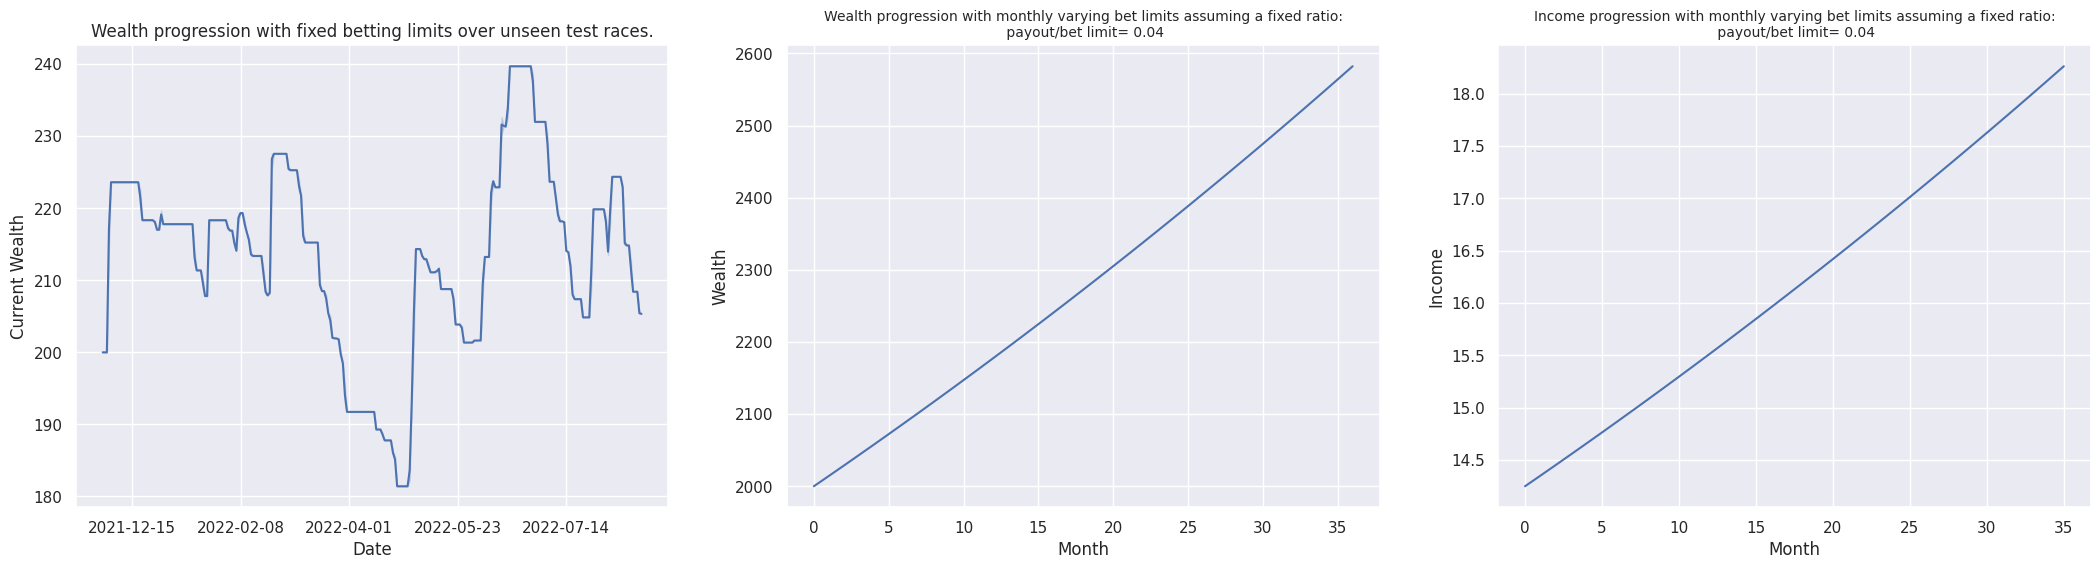

In [2]:
import pickle

FUND_HISTORY_SUMMARIES_PATH = "../data/fund_history_summaries.dat"

with open(FUND_HISTORY_SUMMARIES_PATH, "rb") as f:
    fund_history_summaries = pickle.load(f)

summary = fund_history_summaries[0]
win_bet_limit_ratio = (summary.total_payout / (summary.n_samples / 1000)) / 20

show_fund_history_summaries_table(fund_history_summaries)
show_fund_snapshot_graphs(fund_history_summaries, win_bet_limit_ratio)

Average positive wealth start: 382.8107
1354.0999999999985


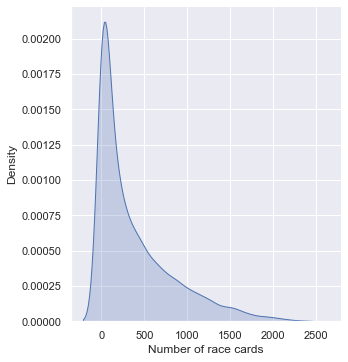

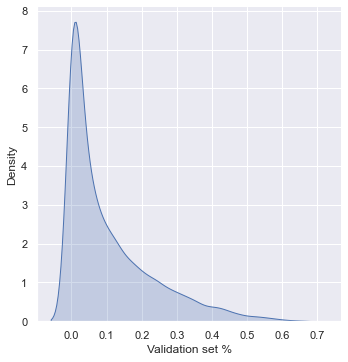

In [5]:
from statistics import mean
import random

def get_positive_wealth_start_idx(payouts: List[float], start_wealth: float):
    wealth_snapshots = [0]
    wealth = start_wealth

    payouts = random.sample(payouts, k=len(payouts))
    for payout in payouts:
        wealth += payout
        wealth_snapshots.append(wealth)

    for bet_slip_idx, wealth_snapshot in enumerate(reversed(wealth_snapshots)):
        if wealth_snapshot < start_wealth:
            return len(wealth_snapshots) - bet_slip_idx - 1

    return 0

payouts = fund_history_summaries[0].payouts
start_wealth = fund_history_summaries[0].start_wealth
positive_wealth_starts = [get_positive_wealth_start_idx(payouts, start_wealth) for _ in range(10000)]
relative_positive_wealth_starts = [positive_wealth_start / len(payouts) for positive_wealth_start in positive_wealth_starts]

print(f"Average positive wealth start: {mean(positive_wealth_starts)}")
print(np.percentile(positive_wealth_starts, q=95))
ax = sns.displot(x=positive_wealth_starts, kind="kde", fill=True)
ax.set_axis_labels(x_var="Number of race cards")

ax = sns.displot(x=relative_positive_wealth_starts, kind="kde", fill=True)
ax.set_axis_labels(x_var="Validation set %")